# Python: Choice of learners for double machine learning

This notebooks contains some practical recommendations to choose the right learner and evaluate different learners for the corresponding nuisance components. It is an extension of the [DoubleML package example on learner selection](https://docs.doubleml.org/stable/examples/py_double_ml_learner.html), adding an example with non-linear data. It is a small introduction to
Double-Machine Learning that you will cover more in depth in the following course.

First, we will work with a simulated linear model for the data generating process and compare different learners for the nuisance components. In the second part, we will work with a non-linear data generating process and compare different learners for the nuisance components.

## Linear Partial Linear Regression Model (PML)
Let $D$ the treatment, $Y$ the outcome, $X$ the confounders, $\theta$ the targeted causal effect (here supposed to be constent).

A PML is of the form:
$Y = \theta D + g(X)+ \epsilon$ with  $\epsilon$ the residual noise, supposed to be mean zero $\mathbb E[\epsilon|D, X]=0$.

We can solve for $\theta$ by debiaising both the treatment and the outcome, then solving the debiased the normal equation.
1. $\tilde{D} = D - \hat{m_0}(X)$ with $\hat{m_0}$ targeting $E[D|X]$
1. $\tilde{Y} = Y - \hat{\ell}(X)$ with $\hat{\ell}$ targeting $E[Y|X]$
3. Solving the normal equation: $\mathbb E [(\tilde{Y} - \beta \tilde{D})\tilde{D}]=0$

This procedure is quite general, but the second point is easy with the hypothesis of a PML: In this case, solving the normal equation sums up to find $\hat{\beta}$ by solving the OLS of $\tilde{Y}$ on $\tilde{D}$.
You will see the theoretical aspects of PLM in session 6.

### Linear PML
For the first example, we will work with a linear PML.
The data generation process for this data has the following form:
$$d_i = m_0(x_i) + s_1 v_i \quad with\; v_i \sim \mathcal{N}(0,1)$$
$$y_i = \alpha d_i + g_0(x_i) + s_2 \zeta_i \quad with\; \zeta_i \sim \mathcal{N}(0,1)$$
with covariates
$x_i \sim \mathcal{N}(0, \Sigma)$, where  $\Sigma$ is a matrix with entries
$\Sigma_{kj} = 0.7^{|j-k|}$.
The nuisance functions are given by:
$$m_0(x_i) = a_0 x_{i,1} + a_1 \frac{\exp(x_{i,3})}{1+\exp(x_{i,3})}$$
$$g_0(x_i) = b_0 \frac{\exp(x_{i,1})}{1+\exp(x_{i,1})} + b_1 x_{i,3}$$

To enforce linearity, we will set to 0 the non linear components: $a_0=0, a_1=1, s_1=0, b_0=0$

## Selection for linear PLM
To be able to compare the properties of different learners, we will start by setting the true treatment parameter to zero, fix some other parameters of the data generating process and generate several datasets
to obtain some information about the distribution of the estimators.

In [1]:
# # Installation of doubleml
!pip install doubleml


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import doubleml as dml
import re # for string manipulation
from doubleml.datasets import make_plr_CCDDHNR2018

theta = 0
n_obs = 500
dim_x = 5
n_rep = 50

np.random.seed(42)
datasets = []
for i in range(n_rep):
    data = make_plr_CCDDHNR2018(
        theta=theta,
        n_obs=n_obs,
        dim_x=dim_x,
        R2_d=0.8,
        R2_y=0.8,
        a_0=0,
        a_1=1,
        s_1=0,
        b_0=0,
        return_type="DataFrame",
    )
    data["d"] = (data["d"] >= 0.5).astype(int)
    datasets.append(dml.DoubleMLData(data, "y", "d"))

For simplicity, we will restrict ourselves to the comparison of two different types and evaluate a learner of linear type and a tree based estimator for each nuisance component (with default hyperparameters).

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import (
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.base import clone

reg_learner_1 = LinearRegression()
reg_learner_2 = GradientBoostingRegressor()
class_learner_1 = LogisticRegressionCV()
class_learner_2 = GradientBoostingClassifier()

learner_list = [
    {"ml_l": reg_learner_1, "ml_m": class_learner_1},
    {"ml_l": reg_learner_2, "ml_m": class_learner_1},
    {"ml_l": reg_learner_1, "ml_m": class_learner_2},
    {"ml_l": reg_learner_2, "ml_m": class_learner_2},
]

In all combinations, we now can try to evaluate four different PLM models. To make the comparison fair, we will apply all different models to the same cross-fitting samples (usually this should not matter, we only consider this here to get slightly cleaner comparison).

Standard approach: At first, we will look at the most straightforward approach using the inbuild nuisance losses. The `nuisance_loss` attribute contains the out-of-sample RMSE or Log Loss for the nuisance functions. We will save all RMSEs and the corresponding treatment estimates for all combinations of learners over all repetitions.

In [4]:
from doubleml.utils import DoubleMLResampling

coefs = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
loss_ml_m = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
loss_ml_l = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)

coverage = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)

for i_rep in range(n_rep):
    print(f"\rProcessing: {round((i_rep+1)/n_rep*100, 3)} %", end="")
    dml_data = datasets[i_rep]
    # define the sample splitting
    smpls = DoubleMLResampling(
        n_folds=5, n_rep=1, n_obs=n_obs, stratify=dml_data.d
    ).split_samples()

    for i_learners, learners in enumerate(learner_list):
        np.random.seed(42)
        dml_plm = dml.DoubleMLPLR(
            obj_dml_data=dml_data,
            ml_l=clone(learners["ml_l"]),
            ml_m=clone(learners["ml_m"]),
            draw_sample_splitting=False,
        )
        dml_plm.set_sample_splitting(smpls)
        dml_plm.fit(n_jobs_cv=5)

        coefs[i_rep, i_learners] = dml_plm.coef[0]
        loss_ml_m[i_rep, i_learners] = dml_plm.nuisance_loss["ml_m"][0][0]
        loss_ml_l[i_rep, i_learners] = dml_plm.nuisance_loss["ml_l"][0][0]

        confint = dml_plm.confint()
        coverage[i_rep, i_learners] = (confint["2.5 %"].iloc[0] <= theta) & (
            confint["97.5 %"].iloc[0] >= theta
        )

Processing: 2.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 4.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 6.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 8.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 10.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 12.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 14.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 16.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 18.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 20.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 22.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 24.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 26.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 28.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 30.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 32.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 34.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 36.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 38.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 40.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 42.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 44.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 46.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 48.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 50.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 52.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 54.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 56.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 58.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 60.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 62.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 64.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 66.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 68.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 70.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 72.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 74.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 76.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 78.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 80.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 82.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 84.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 86.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 88.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 90.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 92.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 94.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 96.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 98.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Processing: 100.0 %

/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


/home/mdoutreligne/research/causal-ml-course-practical-sessions/.venv/lib/python3.12/site-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner LogisticRegressionCV() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [5]:
colnames = []
for learner in learner_list:
    l_name = re.sub('Regressor|Regression|CV|Gradient', '', learner['ml_l'].__class__.__name__)
    m_name = re.sub('Classifier|CV|Regression|Gradient', '', learner['ml_m'].__class__.__name__)
    colnames.append(f"{l_name} + {m_name}")

coverage_df = pd.DataFrame(coverage, columns=colnames)
print(f"\nCoverage: {coverage_df.mean(0)}")


Coverage: Linear + Logistic      0.92
Boosting + Logistic    0.94
Linear + Boosting      0.60
Boosting + Boosting    0.62
dtype: float64


Next, let us take a look at the corresponding results.

In [6]:

df_coefs = pd.DataFrame(coefs, columns=colnames)
df_ml_m = pd.DataFrame(loss_ml_m, columns=colnames)
df_ml_l = pd.DataFrame(loss_ml_l, columns=colnames)

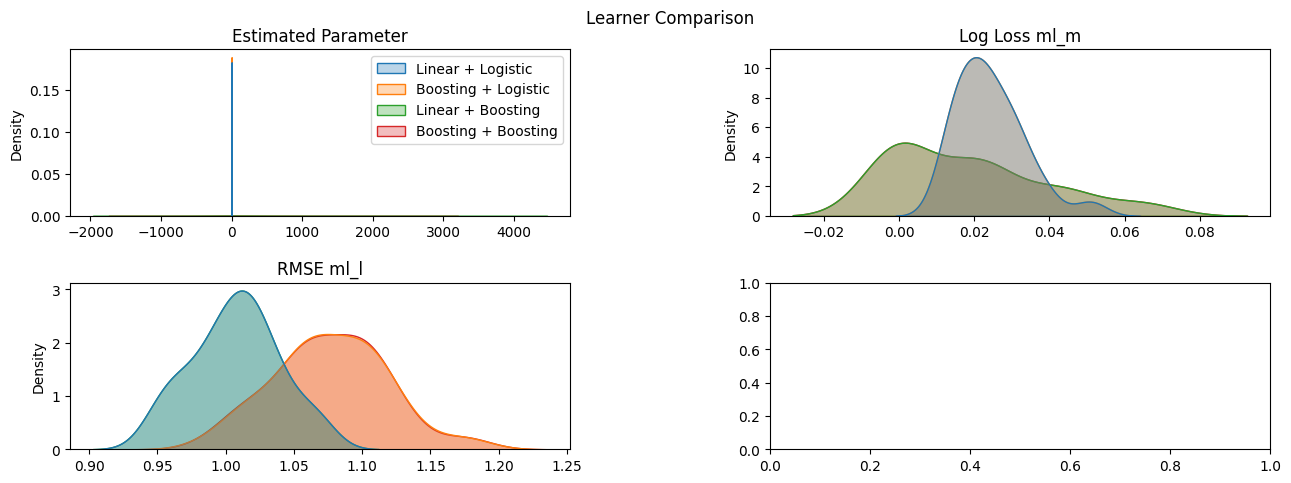

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle("Learner Comparison")

sns.kdeplot(data=df_coefs, ax=axes[0][0], fill=True, alpha=0.3)
sns.kdeplot(data=df_ml_m, ax=axes[0][1], fill=True, alpha=0.3, legend=False)
sns.kdeplot(data=df_ml_l, ax=axes[1][0], fill=True, alpha=0.3, legend=False)

axes[0][0].title.set_text("Estimated Parameter")
# axes[0][0].set_xlim(-10, 10)
axes[0][1].title.set_text("Log Loss ml_m")
axes[1][0].title.set_text("RMSE ml_l")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

### 📝 TODO For which combination of the nuisance learners are some of the coefficients are way greater than others? Can you explain why there are these outliers ? 

In [8]:
mask_high_coefs =(df_coefs > 100).any(axis=1)

Some coefficients are extreme, only for the experiments with a boosting model for the treatment assignment. These extrem values are probably due to extrem values of the predicted probability to be treated: either too close from 0 or from 1. Such extrem values leads to instability in the coefficient estimation. Indead, remember that the coefficient for the PLM is: 
$$\hat{\beta} = \frac{\mathbb E[(Y - \hat{l}(X))(D-\hat{m}(X))]}{\mathbb E[(D-\hat{m}(X))^2]}$$

We can now easily observe that in this setting, the linear learners are able to approximate the corresponding nuisance functions better than the boosting algorithm (as should be expected since the data is generated accordingly).

Let us take a look at what would have happend if for each repetition, we would have selected the combination of learners with the smallest out-of-sample loss (in our example this corresponds to minimizing the product of losses).

In [9]:
selected_learners = (loss_ml_m * (loss_ml_l)).argmin(axis=1)
np.unique(selected_learners, return_counts=True)

(array([0, 2]), array([19, 31]))

Let us compare which learners, how the estimated coefficients would have performed with the selected learners.

Coverage of selected learners: 0.78


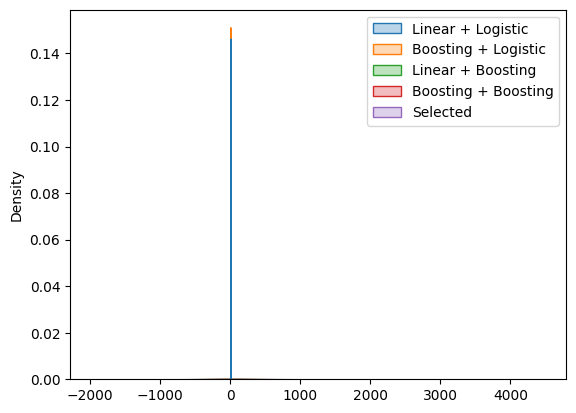

In [10]:
print(
    f"Coverage of selected learners: {np.mean(np.array([coverage[i_rep, selected_learners[i_rep]] for i_rep in range(n_rep)]))}"
)

selected_coefs = np.array(
    [coefs[i_rep, selected_learners[i_rep]] for i_rep in range(n_rep)]
)
df_coefs["Selected"] = selected_coefs
sns.kdeplot(data=df_coefs, fill=True, alpha=0.3)
plt.show()

This procedure will be generally valid as long as we do not compare a excessively large number of different learners.
### Non-linear PLM
### 📝 TODO Repeat this procedure for a non-linear data generation process.

In [11]:
theta = 0
n_obs = 500
dim_x = 5
n_rep = 50

np.random.seed(42)
datasets_non_linear = []
for i in range(n_rep):
    data = make_plr_CCDDHNR2018(
        theta=theta,
        n_obs=n_obs,
        dim_x=dim_x,
        R2_d=0.8,
        R2_y=0.8,
        a_0=1,
        a_1=1,
        s_1=0.5,
        b_0=1,
        return_type="DataFrame",
    )
    data["d"] = (data["d"] >= 0.5).astype(int)
    datasets_non_linear.append(dml.DoubleMLData(data, "y", "d"))

In [12]:
from doubleml.utils import DoubleMLResampling

coefs = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
loss_ml_m = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
loss_ml_l = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)

coverage = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)

for i_rep in range(n_rep):
    print(f"\rProcessing: {round((i_rep+1)/n_rep*100, 3)} %", end="")
    dml_data = datasets_non_linear[i_rep]
    # define the sample splitting
    smpls = DoubleMLResampling(
        n_folds=5, n_rep=1, n_obs=n_obs, stratify=dml_data.d
    ).split_samples()

    for i_learners, learners in enumerate(learner_list):
        np.random.seed(42)
        dml_plm = dml.DoubleMLPLR(
            obj_dml_data=dml_data,
            ml_l=clone(learners["ml_l"]),
            ml_m=clone(learners["ml_m"]),
            draw_sample_splitting=False,
        )
        dml_plm.set_sample_splitting(smpls)
        dml_plm.fit(n_jobs_cv=5)

        coefs[i_rep, i_learners] = dml_plm.coef[0]
        loss_ml_m[i_rep, i_learners] = dml_plm.nuisance_loss["ml_m"][0][0]
        loss_ml_l[i_rep, i_learners] = dml_plm.nuisance_loss["ml_l"][0][0]

        confint = dml_plm.confint()
        coverage[i_rep, i_learners] = (confint["2.5 %"].iloc[0] <= theta) & (
            confint["97.5 %"].iloc[0] >= theta
        )

Processing: 2.0 %

Processing: 4.0 %

Processing: 6.0 %

Processing: 8.0 %

Processing: 10.0 %

Processing: 12.0 %

Processing: 14.0 %

Processing: 16.0 %

Processing: 18.0 %

Processing: 20.0 %

Processing: 22.0 %

Processing: 24.0 %

Processing: 26.0 %

Processing: 28.0 %

Processing: 30.0 %

Processing: 32.0 %

Processing: 34.0 %

Processing: 36.0 %

Processing: 38.0 %

Processing: 40.0 %

Processing: 42.0 %

Processing: 44.0 %

Processing: 46.0 %

Processing: 48.0 %

Processing: 50.0 %

Processing: 52.0 %

Processing: 54.0 %

Processing: 56.0 %

Processing: 58.0 %

Processing: 60.0 %

Processing: 62.0 %

Processing: 64.0 %

Processing: 66.0 %

Processing: 68.0 %

Processing: 70.0 %

Processing: 72.0 %

Processing: 74.0 %

Processing: 76.0 %

Processing: 78.0 %

Processing: 80.0 %

Processing: 82.0 %

Processing: 84.0 %

Processing: 86.0 %

Processing: 88.0 %

Processing: 90.0 %

Processing: 92.0 %

Processing: 94.0 %

Processing: 96.0 %

Processing: 98.0 %

Processing: 100.0 %

In [13]:
colnames = []
for learner in learner_list:
    l_name = re.sub('Regressor|Regression|CV|Gradient', '', learner['ml_l'].__class__.__name__)
    m_name = re.sub('Classifier|CV|Regression|Gradient', '', learner['ml_m'].__class__.__name__)
    colnames.append(f"{l_name} + {m_name}")

coverage_df = pd.DataFrame(coverage, columns=colnames)
print(f"\nCoverage: {coverage_df.mean(0)}")


Coverage: Linear + Logistic      0.16
Boosting + Logistic    0.18
Linear + Boosting      0.32
Boosting + Boosting    0.30
dtype: float64


Next, let us take a look at the corresponding results.

In [14]:

df_coefs = pd.DataFrame(coefs, columns=colnames)
df_ml_m = pd.DataFrame(loss_ml_m, columns=colnames)
df_ml_l = pd.DataFrame(loss_ml_l, columns=colnames)

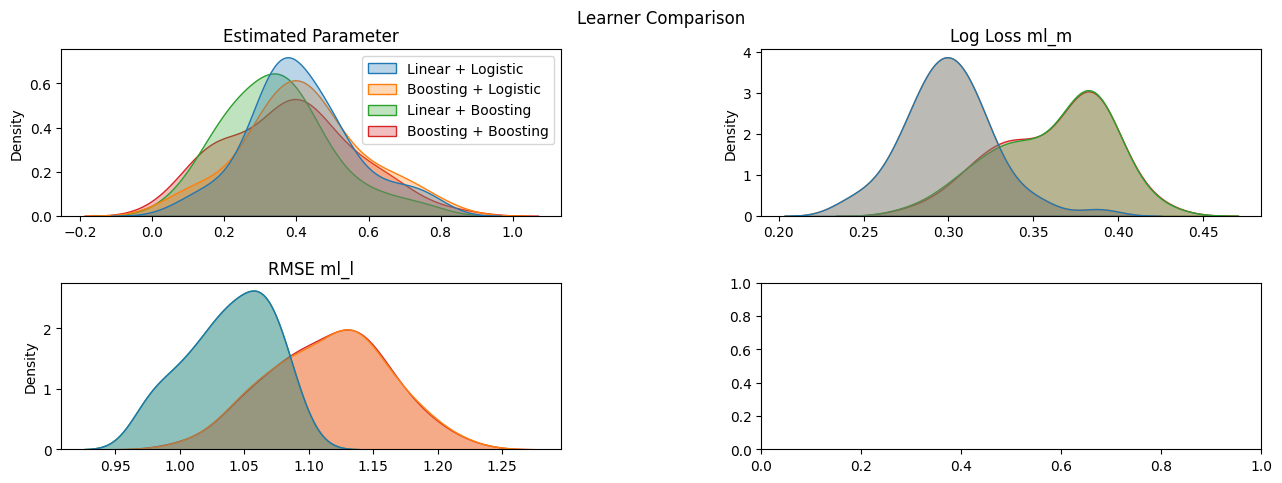

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle("Learner Comparison")

sns.kdeplot(data=df_coefs, ax=axes[0][0], fill=True, alpha=0.3)
sns.kdeplot(data=df_ml_m, ax=axes[0][1], fill=True, alpha=0.3, legend=False)
sns.kdeplot(data=df_ml_l, ax=axes[1][0], fill=True, alpha=0.3, legend=False)

axes[0][0].title.set_text("Estimated Parameter")
# axes[0][0].set_xlim(-10, 10)
axes[0][1].title.set_text("Log Loss ml_m")
axes[1][0].title.set_text("RMSE ml_l")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

For non-linear data generation process, recovering the nuisance functions is more difficult. We see that the coverages are lower than for the linear case. The boosting models when used for the treatment assignment mechanism $m$ seems to be more efficient to recover the correct parameters. On the countrary, modeling the outcome $l$ by either a linear model or a boosting model does not seem to have a big impact on the treatment parameter estimation.